<a href="https://colab.research.google.com/github/claredavies/Image3DCoursework/blob/main/MatchDescriptors/MatchDescriptors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Correspondence between images

## Import Libraries

In [65]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from skimage.io import imread, imshow
from skimage import transform

## Read in Files

In [66]:
!git clone https://github.com/claredavies/Image3DCoursework.git

Cloning into 'Image3DCoursework'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 166 (delta 4), reused 0 (delta 0), pack-reused 150
Receiving objects: 100% (166/166), 27.12 MiB | 26.40 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [67]:
%cd Image3DCoursework/MatchDescriptors

/content/Image3DCoursework/MatchDescriptors/Image3DCoursework/MatchDescriptors


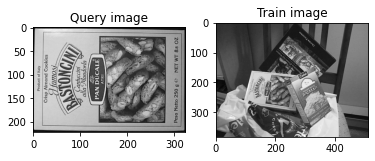

In [68]:
img1 = cv2.imread('input/box.png',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('input/box_in_scene.png',cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1)
plt.title("Query image")
plt.imshow(img1, cmap="gray");

plt.subplot(1,2,2)
plt.title("Train image")
plt.imshow(img2, cmap="gray");

## Try Out Descriptors

Let's see step by step how an OpenCV blob detector works. Next example uses SIFT algorithm, other algorithms like SURF, FAST, ... follows the same usage pattern.

Let's execute the algorithm with parameters default values. Variables kp1 and kp2 will contain the detected keypoints in each images. And variables des1 and des2 will contain its descriptors.

In [69]:
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

In [70]:
kp1[0].pt

(3.4104702472686768, 216.3043975830078)

> Brute-force descriptor matcher. (BFMatcher)

> For each descriptor in the first set, this matcher finds the closest descriptor in the second set by trying each one. This descriptor matcher supports masking permissible matches of descriptor sets.


In [71]:
bf = cv2.BFMatcher_create()
matches = bf.knnMatch(des1, des2, k=2) # k = 2 -> Two points matching

In [72]:
type(matches)

tuple

In [73]:
matches[0]

(< cv2.DMatch 0x7fb28db65490>, < cv2.DMatch 0x7fb29c705d50>)

In [74]:
type(matches[0][0])

cv2.DMatch

In [75]:
# Filter the most representative keypoints according to its distance (computed using KNN)
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

At the end OpenCV have a function to ease the visual representation of the detected and selected keypoints.

[Drawing keypoints and matches documentation](https://docs.opencv.org/3.4/d4/d5d/group__features2d__draw.html)

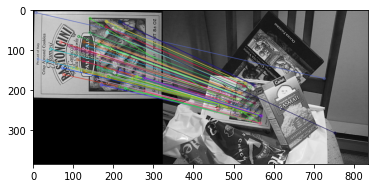

In [76]:
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3);

## Interesting links

* https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html 

* https://docs.opencv.org/4.x/d1/de0/tutorial_py_feature_homography.html

## Homework

1. Construct the panoramic view of the next two images using four points manually selected.
2. Try out several descriptors you have seen in theory classes (Harris, SIFT, SURF, ...)
3. Construct the panoramic view of the next two images using the keypoints obtained with the previous algorithms.

### Read the images

Once we have imported the required libraries, we are going to load two images from the same building for the aim to do a panoramic view. 
We read both images and convert it to grayscale. We don't override colour images as we are going to use it for pretty visualisation.

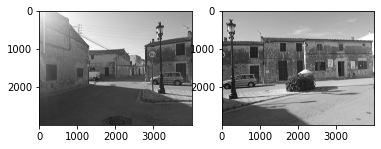

In [77]:
img1 = cv2.imread("input/edifici1.jpg")
img2 = cv2.imread("input/edifici2.jpg")

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

plt.subplot(1,2,1)
plt.imshow(img1_gray, cmap="gray");

plt.subplot(1,2,2)
plt.imshow(img2_gray, cmap="gray");

### Exercise 1

Select four keypoints manually:

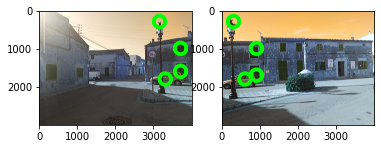

In [78]:
debug_img1 = img1.copy()
debug_img2 = img2.copy()

srcPts = [(3150,300), (3300, 1800), (3700, 1600), (3700, 1000)]
dstPts = [(300,300), (600, 1800), (900, 1700), (900, 1000)]

for srcPt in srcPts:
  cv2.circle(debug_img1, (int(srcPt[0]), int(srcPt[1])), 150, (0, 255, 0), 100)

for dstPt in dstPts:
  cv2.circle(debug_img2, (int(dstPt[0]), int(dstPt[1])), 150, (0, 255, 0), 100)

plt.subplot(1,2,1)
plt.imshow(debug_img1);

plt.subplot(1,2,2)
plt.imshow(debug_img2);  

#### Homography
Once we have the 4 correspondent points let's do the homography of both images
* https://learnopencv.com/homography-examples-using-opencv-python-c/

In [93]:
src = np.float32(srcPts).reshape(-1,1,2)
dst = np.float32(dstPts).reshape(-1,1,2)

In [81]:
# TODO:  cv2.findHomography
M, mask = cv2.findHomography(src, dst, cv2.RANSAC,5.0)

#### *Warp* images
Finally, we convert the destination images to the origin image plane.

In [84]:
def project_transform(srcImage, dstImage, src, dst):
    x_dst = [val[0] for val in dst] + [dst[0][0]]
    y_dst = [val[1] for val in dst] + [dst[0][1]]

    tform = transform.estimate_transform('projective', 
                                         np.array(src), 
                                         np.array(dst))
    transformed = transform.warp(srcImage, tform.inverse)
    
    plt.subplot(1,3,1)
    plt.imshow(img1, cmap="gray");

    plt.subplot(1,3,2)
    plt.imshow(img2, cmap="gray");

    plt.subplot(1,3,3)
    plt.imshow(transformed, cmap="gray");

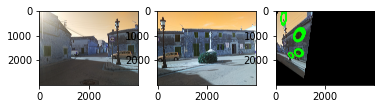

In [85]:
project_transform(debug_img1, debug_img2, srcPts, dstPts)

### Exercise 2

#### Select a descriptor

In the next cell you must initialize a descriptor object (different of SIFT) as we have done previously:


#### Extract keys and descriptors

Extract keys and descriptors using OpenCV *common* module

In [86]:
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

In [87]:
print(des1)

[[ 0. 10. 83. ...  0.  0.  1.]
 [ 7.  8. 30. ...  2.  5. 21.]
 [11. 21.  9. ...  0.  0.  0.]
 ...
 [90. 48. 10. ...  0.  0.  0.]
 [ 0.  0.  0. ...  1.  7. 25.]
 [ 8.  0.  0. ... 15.  0.  3.]]


With the descriptors obtained in this step let's perform a correspondence operation and a filtering one.

### Exercise 3

In [88]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

In [89]:
# TODO: Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [90]:
print(good)

[< cv2.DMatch 0x7fb29eb60870>, < cv2.DMatch 0x7fb29eb613b0>, < cv2.DMatch 0x7fb29eb754f0>, < cv2.DMatch 0x7fb29eb77730>, < cv2.DMatch 0x7fb29eb89f30>, < cv2.DMatch 0x7fb29eb8fab0>, < cv2.DMatch 0x7fb29eb95a70>, < cv2.DMatch 0x7fb29eb270b0>, < cv2.DMatch 0x7fb29eb39b70>, < cv2.DMatch 0x7fb29eb3dcf0>, < cv2.DMatch 0x7fb29eb3fdb0>, < cv2.DMatch 0x7fb29eb41e30>, < cv2.DMatch 0x7fb29eae9bf0>, < cv2.DMatch 0x7fb29eaed8b0>, < cv2.DMatch 0x7fb29e9ef1b0>, < cv2.DMatch 0x7fb29e9f9730>, < cv2.DMatch 0x7fb29e9ff730>, < cv2.DMatch 0x7fb29ea05730>, < cv2.DMatch 0x7fb29e9996b0>, < cv2.DMatch 0x7fb29e99fdf0>, < cv2.DMatch 0x7fb29e9abf70>, < cv2.DMatch 0x7fb29e9b57f0>, < cv2.DMatch 0x7fb29e9bb430>, < cv2.DMatch 0x7fb29e9cd530>, < cv2.DMatch 0x7fb29e95dbb0>, < cv2.DMatch 0x7fb29e95ffb0>, < cv2.DMatch 0x7fb29e963ef0>, < cv2.DMatch 0x7fb29e96b470>, < cv2.DMatch 0x7fb29e96d9f0>, < cv2.DMatch 0x7fb29e96ff70>, < cv2.DMatch 0x7fb29e9737b0>, < cv2.DMatch 0x7fb29e9757f0>, < cv2.DMatch 0x7fb29e9759b0>, < cv2.DMa

#### Homography

With the previously obtained correspondences, we can perform an homography between both images.

* https://learnopencv.com/homography-examples-using-opencv-python-c/

In [91]:
# TODO:  cv2.findHomography
MIN_MATCH_COUNT = 2

if len(good)>MIN_MATCH_COUNT:
    src_list = [kp1[m.queryIdx].pt for m in good]
    dst_list = [kp2[m.trainIdx].pt for m in good]
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

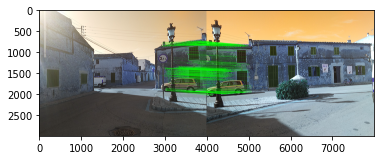

(<matplotlib.image.AxesImage at 0x7fb29efd1970>, None)

In [92]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()

#### *Warp* images

Finally transform the destination image to the origin image plane.

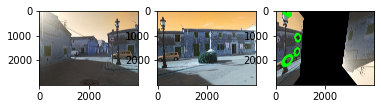

In [62]:
project_transform(debug_img1, debug_img2, src_list, dst_list)